# Recommender Systems
### NA Handle

In [45]:
# deleting anime with 0 rating
anime_df=anime_df[~np.isnan(anime_df["rating"])]

# filling mode value for genre and type
anime_df['genre'] = anime_df['genre'].fillna(
anime_df['genre'].dropna().mode().values[0])

anime_df['type'] = anime_df['type'].fillna(
anime_df['type'].dropna().mode().values[0])

#checking if all null values are filled
anime_df.isnull().sum()

anime_id      0
name          0
genre         0
type          0
episodes      0
rating        0
members       0
vote count    0
dtype: int64

In [46]:
#rating with -1 are missing and useless values
rating_df = rating_df[rating_df["rating"]!=-1]

print(f"rating shape: {rating_df.shape}\nanime shape: {anime_df.shape}")

rating shape: (6337241, 3)
anime shape: (9924, 8)


In [47]:
#step 2
rated_anime = rating_df.merge(anime_df, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
rated_anime = rated_anime[["user_id","type","anime_id","name","rating_user","rating"]]
rated_anime.shape

(6337234, 6)

In [48]:
rated_anime.head()

,user_id,type,anime_id,name,rating_user,rating
0,1,TV,8074,Highschool of the Dead,10,7.46
1,3,TV,8074,Highschool of the Dead,6,7.46
2,5,TV,8074,Highschool of the Dead,2,7.46
3,12,TV,8074,Highschool of the Dead,6,7.46
4,14,TV,8074,Highschool of the Dead,6,7.46


## Demographic Filtering -
**Requierments:**
* Metric to score item
* Calculate the score for every item.
* Sort the scores and recommend the best rated movie to the users.

### Chosen metric: Bayesyan average

Averaged bayesian rating formula: $R_{\beta} = w*R + (1-w)*R_{0}$ 

($w = \frac n N_{max}$)
* $w$ - Weight factor: $\lim_{x \to 0_{+}}$ means few votes  $\lim_{x \to 1_{-}}$ means many votes.
* $R$ - Individual rating: average rating for this item.
* $R_{0}$ - global average rating, for all items in your database.
* $n$ - number of votes for this item.
* $N_{max}$ - maximum number of votes for all items.

**Types of items**: TV, Music, Movie, OVA, ONA, Special

Ratings are specified for each of these item types individualy.

In [49]:
def sorter(column):
    """
    this sorts the names of the anime by a specific order
    """
    reorder = rated_anime.name.value_counts().index.tolist()
    
    # This also works:
    # mapper = {name: order for order, name in enumerate(reorder)}
    # return column.map(mapper)
    cat = pd.Categorical(column, categories=reorder, ordered=True)
    return pd.Series(cat)

anime_df = anime_df[anime_df["name"].isin(rated_anime.name.value_counts().index.tolist())].sort_values(by = "name" , key = sorter)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,vote count
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,34226
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100,26310
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,25290
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,24126
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796,23565


In [50]:
anime_df[anime_df["name"]=="Saru Kani Gassen"]

,anime_id,name,genre,type,episodes,rating,members,vote count
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76,2


In [51]:
anime_df = anime_df[~((anime_df["name"]=="Saru Kani Gassen")&(anime_df["type"]=="OVA"))] #remove a duplicate anime

In [52]:
anime_df["vote count"] = rated_anime.name.value_counts().tolist() 

### Reccomended anime function

the function works in the following way:
1. the function is copying the dataset.
2. a filter is activated to get the top 10% voted anime (90% percentile).
3. gets the variables needed for the defined score metric and calculated it.
4. outputs the top 10 Trending anime.

In [53]:
#filter
def filter_agg(x):
    return x.quantile(0.9)

anime_rating_filter = anime_df.groupby(by = "type").agg(filter_agg)["vote count"]

def Recommended_anime(Type = None):
    """
    returns top 10 anime in a specific type of anime (TV, OVA, Movie etc.)
    """
    df = anime_df.copy()
    df = df[df["type"]==Type].loc[df['vote count'] >= anime_rating_filter[Type]]
    N_max = df[df["type"]==Type]["vote count"].max()
    R0 = df[df["type"]==Type]["rating"].mean()
    R = df[df["type"]==Type]["rating"]
    n = df[df["type"]==Type]["vote count"]
    w = n/N_max
    df["Score"] = w*R + (1-w)*R0 #Bayesyan average
    df = df.sort_values('Score', ascending=False)[:10]
    print(f"Recommended in {Type}:")
    return df[["name","Score"]].style.hide_index()#hide index

C:\Users\97254\anaconda3\envs\torch\lib\site-packages\pandas\core\groupby\generic.py:303: FutureWarning:

Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.



In [54]:
Recommended_anime("TV")

Recommended in TV:


name,Score
Fullmetal Alchemist: Brotherhood,8.759342
Death Note,8.710000
Code Geass: Hangyaku no Lelouch R2,8.571979
Code Geass: Hangyaku no Lelouch,8.559731
Steins;Gate,8.543463
Clannad: After Story,8.433669
Shingeki no Kyojin,8.376595
Tengen Toppa Gurren Lagann,8.343071
Cowboy Bebop,8.270093
Angel Beats!,8.241774


In [55]:
Recommended_anime("Movie")

Recommended in Movie:


name,Score
Sen to Chihiro no Kamikakushi,8.930000
Mononoke Hime,8.516622
Howl no Ugoku Shiro,8.508852
Suzumiya Haruhi no Shoushitsu,8.239172
Tonari no Totoro,8.179456
Toki wo Kakeru Shoujo,8.177667
Ookami Kodomo no Ame to Yuki,8.170295
Neon Genesis Evangelion: The End of Evangelion,8.097285
Hotaru no Haka,8.083231
Evangelion: 2.0 You Can (Not) Advance,8.064932


In [56]:
Recommended_anime("Music")

Recommended in Music:


name,Score
Shelter,8.237966
Interstella5555: The 5tory of The 5ecret 5tar 5ystem,8.170000
CLAMP in Wonderland 2,7.298844
Black★Rock Shooter,7.261495
On Your Mark,7.207474
The Everlasting Guilty Crown,7.162946
Tengen Toppa Gurren Lagann: Parallel Works,7.160707
Higashi no Eden: Falling Down,7.145067
Tengen Toppa Gurren Lagann: Kirameki★Yoko Box - Pieces of Sweet Stars,7.138649
Snow Halation,7.092173


In [57]:
Recommended_anime("ONA")

Recommended in ONA:


name,Score
Eve no Jikan,7.865627
Ore no Imouto ga Konnani Kawaii Wake ga Nai Specials,7.660000
Hetalia Axis Powers,7.656695
Bounen no Xamdou,7.505628
Hetalia World Series,7.417616
Suzumiya Haruhi-chan no Yuuutsu,7.396014
Plastic Neesan,7.268596
Hetalia: The Beautiful World,7.245433
There She Is!!,7.220638
Seitokai no Ichizon Lv.2,7.217476


In [58]:
Recommended_anime("OVA")

Recommended in OVA:


name,Score
FLCL,8.060000
Hellsing Ultimate,8.054113
Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,7.983917
Detroit Metal City,7.675374
Golden Boy,7.635805
Final Fantasy VII: Advent Children Complete,7.594082
Black Lagoon: Roberta's Blood Trail,7.593630
Tsubasa: Tokyo Revelations,7.572125
Hunter x Hunter: Greed Island Final,7.557157
Hunter x Hunter OVA,7.548033


In [59]:
Recommended_anime("Special")

Recommended in Special:


name,Score
Steins;Gate: Oukoubakko no Poriomania,8.264060
"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",8.140000
Baccano! Specials,7.930564
"Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen",7.926999
Fate/stay night: Unlimited Blade Works - Prologue,7.864494
Darker than Black: Kuro no Keiyakusha Gaiden,7.863995
Kokoro Connect: Michi Random,7.842193
Durarara!! Specials,7.762084
Hajime no Ippo: Champion Road,7.696284
Mushishi Special: Hihamukage,7.681601


### Trending anime plot
A function that plots trends for the types of anime.

In [60]:
def plot_trend(Type = None):
    df = anime_df.copy()
    df = df[df["type"]==Type]
    fig = px.bar(df[["name","members"]].sort_values(by = "members", ascending = False)[:10][::-1], x="name", y="members", color="members", title = f"Trending in {Type}")
    fig.show()

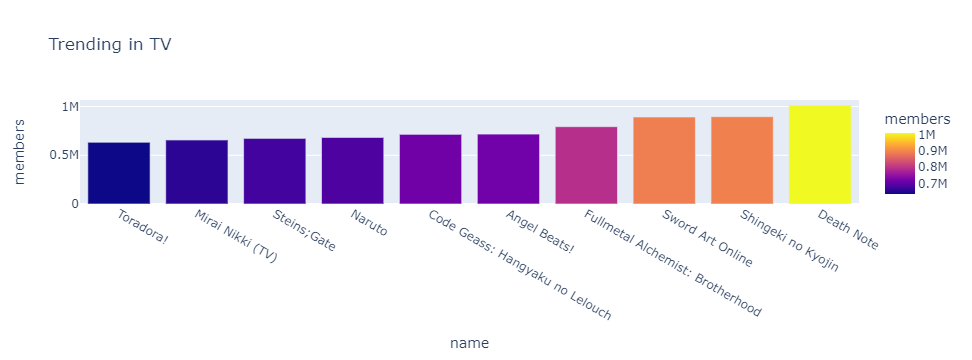

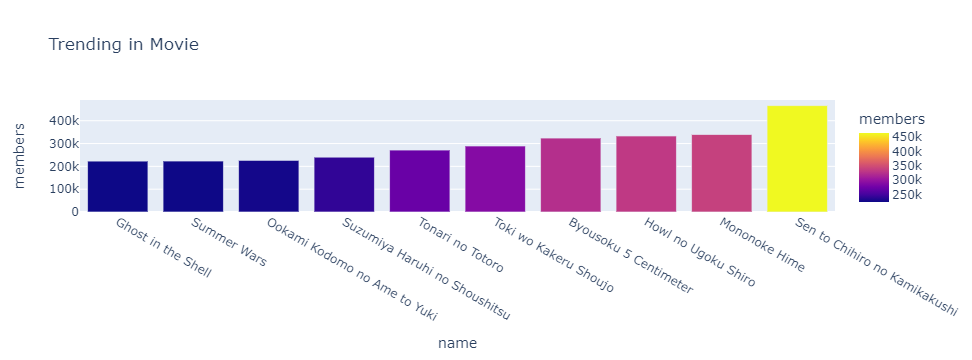

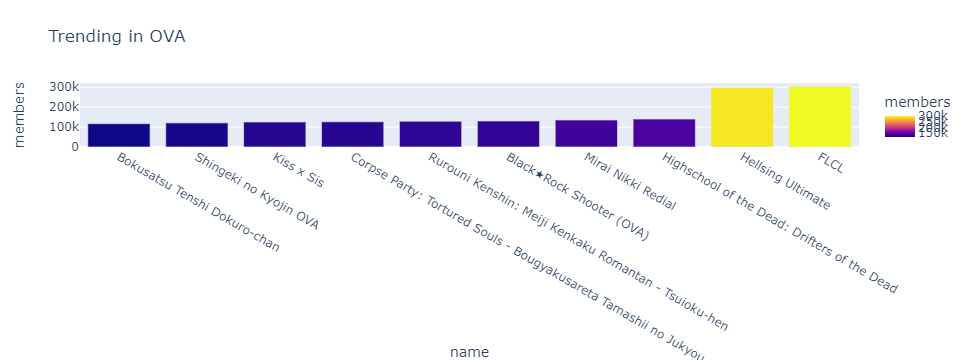

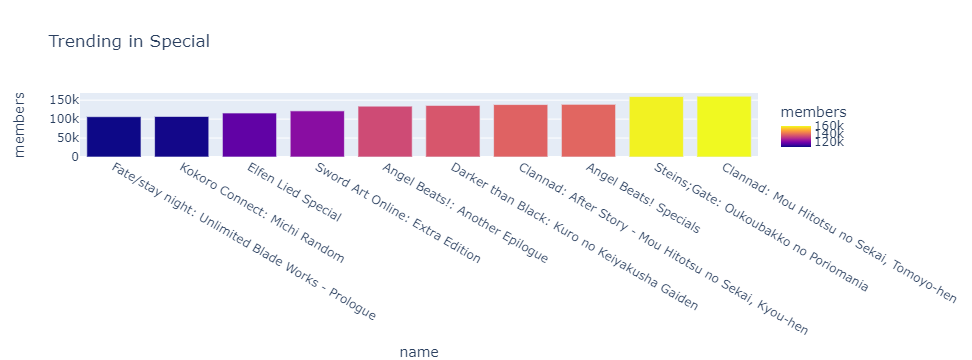

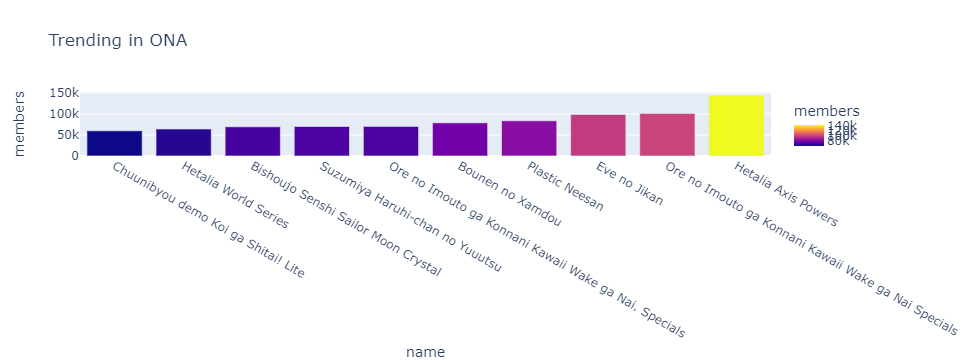

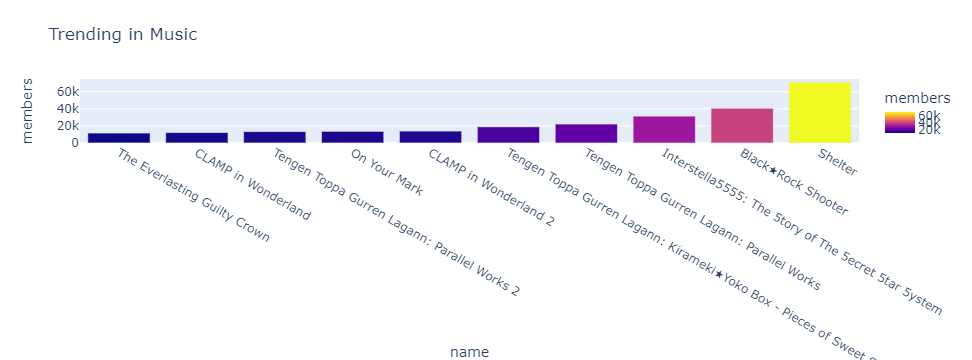

In [61]:
for t in anime_df.type.unique().tolist():
    plot_trend(t)

## Item based Collaborative Filtering

These systems recommend based on similarities between items that are calculated. based on the computed similarities, items similar to already consumed are looked at and recommended accordingly.

In [62]:
%%time
def pivot_type(Type = None):
    pivot = pd.pivot_table(rated_anime[rated_anime["type"]==Type], index='name', columns='user_id', values='rating_user')
    return pivot

All_types = dict(zip([Type for Type in rated_anime.type.unique().tolist()],[pivot_type(Type) for Type in rated_anime.type.unique().tolist()]))
All_types.keys()

Wall time: 14.9 s


dict_keys(['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music'])

In [63]:
#if there are users without ratings drop them
for pivot in All_types.values():
    pivot.dropna(axis=1, how='all', inplace=True)
    print(pivot.shape)

(3069, 68929)
(1754, 50715)
(2730, 47343)
(1448, 40650)
(478, 22833)
(445, 7336)


In [64]:
for pivot in All_types.values():
    print(pivot.shape)

(3069, 68929)
(1754, 50715)
(2730, 47343)
(1448, 40650)
(478, 22833)
(445, 7336)


In [65]:
#normalize values
for key,pivot in All_types.items():
    All_types[key] = pivot.apply(lambda x: x - np.nanmean(x), axis=1)
    All_types[key].fillna(0, inplace=True)

In [66]:
from sklearn.metrics.pairwise import cosine_similarity
# convert into dataframe to make it easier
for key,pivot in All_types.items():
    All_types[key] = pd.DataFrame(cosine_similarity(pivot, pivot), index=pivot.index, columns=pivot.index)
    print(All_types[key].shape)

(3069, 3069)
(1754, 1754)
(2730, 2730)
(1448, 1448)
(478, 478)
(445, 445)


In [67]:
def get_similar_anime(Type, anime_name, n_rec = 10):
    try: 
        if anime_name not in All_types[Type].index:
            return f"please write a proper name for example: {All_types[Type].sample().index.tolist()[0]}"
        else:
            sim_animes = All_types[Type].sort_values(by=anime_name, ascending=False).index[1:n_rec+1].tolist()
            print("you might also like:\n")
            for i,anime in enumerate(sim_animes): 
                print(f"\t#{i+1} {anime}")
    except:
        print(f"check parameters:\n\tType = {Type},anime_name = {anime_name},n_rec = {n_rec}")

In [68]:
get_similar_anime("Special","Takamiya Nasuno Desu!: Teekyuu Spin-off Specials", 20)

you might also like:

	#1 Teekyuu 6 Specials
	#2 Houkago no Ouji-sama
	#3 Prince of Tennis: Message in a Bottle
	#4 Teekyuu 5 Specials
	#5 Sengoku Musou: Sengoku Musou High School
	#6 Daitoshokan no Hitsujikai Picture Drama
	#7 Long Riders Recap
	#8 Dog Days Recap
	#9 Valkyrie Drive: Mermaid Specials
	#10 Owari no Seraph: Nagoya Kessen-hen - Owaranai Seraph - Nagoya Kessen-hen
	#11 Hetalia: The World Twinkle Specials
	#12 Dog Days&#039; Specials
	#13 Sweet Valerian Specials
	#14 Daiakuji: The Xena Buster Specials
	#15 Ushinawareta Mirai wo Motomete: Ushinawareta Natsuyasumi wo Motomete
	#16 Hyakka Ryouran: Samurai After Specials
	#17 Military! Special
	#18 Kuroko no Basket: Oshaberi Demo Shimasen ka
	#19 Ro-Kyu-Bu! SS Recap
	#20 Vanquished Queens Specials


In [69]:
for key in All_types.keys():
    All_types[key].to_csv(f"Data/{key}_similarity.csv", compression='zip')
anime_df.to_csv("Data/demographic_anime.csv")
rated_anime.to_csv("Data/rated_anime.csv")